In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM3.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

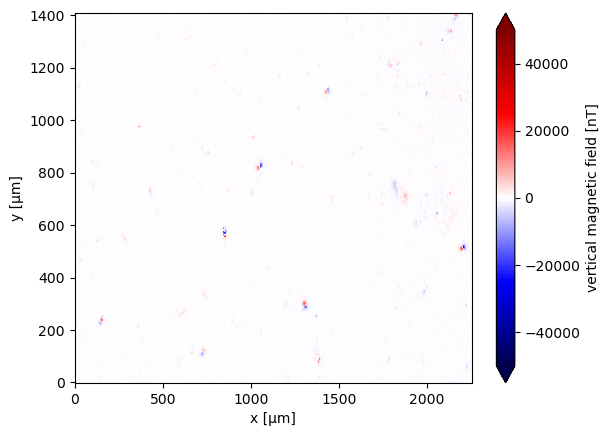

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 2.696 -40.62 -74.4 -78.37 ... 99.04 76.19 54.94

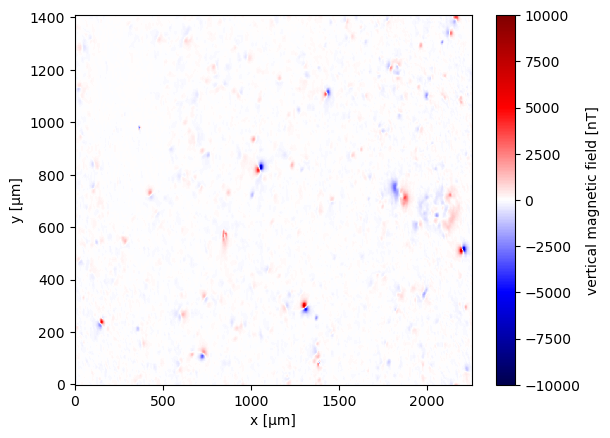

In [8]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [9]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 2.696 -40.62 -74.4 -78.37 ... 99.04 76.19 54.94
    tga      (y, x) float64 5MB 22.78 21.97 25.08 14.21 ... 20.95 16.17 17.39
    x_deriv  (y, x) float64 5MB -18.43 -16.4 -8.033 ... -8.338 -9.381 -9.041
    y_deriv  (y, x) float64 5MB -11.82 -14.1 -14.0 -12.72 ... 11.84 5.481 -2.786
    z_deriv  (y, x) float64 5MB -6.298 3.85 19.2 6.012 ... -15.13 -11.98 -14.59

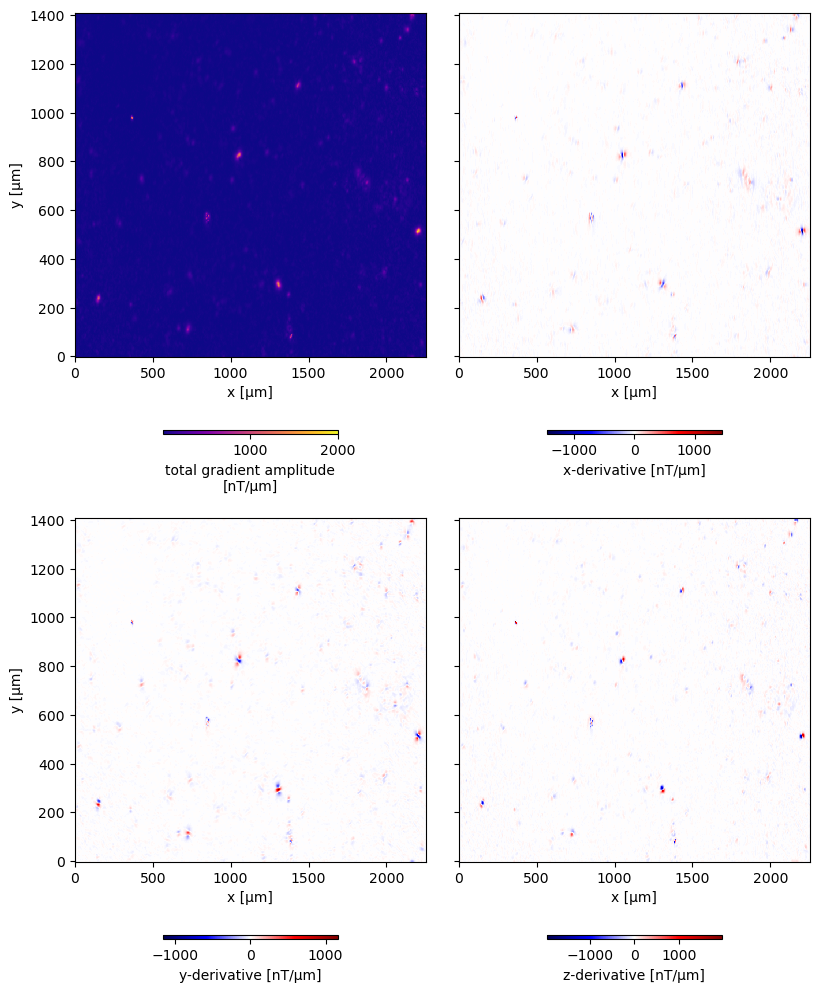

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [11]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

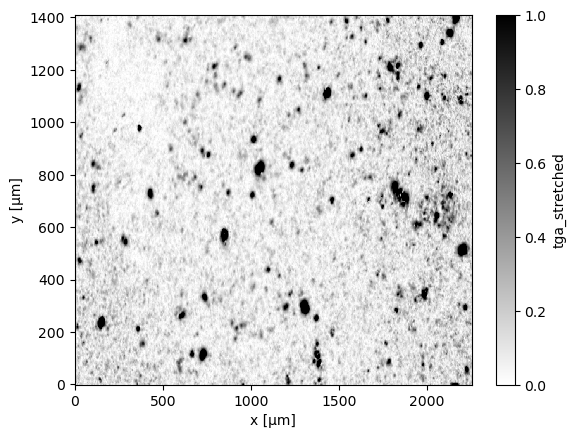

In [12]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [13]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 500],
    size_increment=1.0,
    threshold=0.09,
    overlap=0.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [14]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

382 potential sources detected within 7.2893 seconds


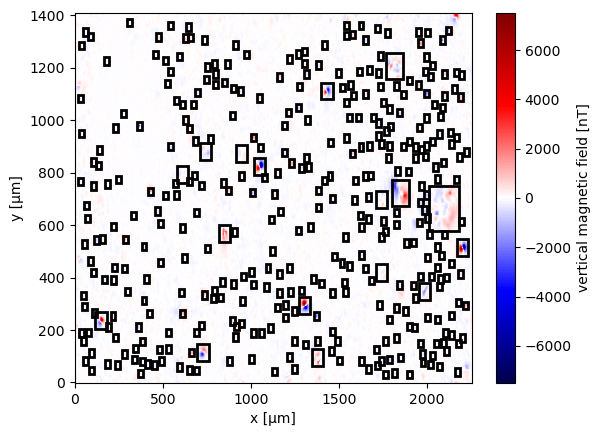

In [15]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [16]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [17]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

382 euler positions and dipole moments estimated within 2.5356 seconds


# Iterative Euler deconvolution

In [18]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [19]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [20]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [21]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 113.5994 seconds


In [22]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x      y     z         bz    z_deriv
0  352.50  963.5  10.0  33.119430  -7.906961
1  354.85  963.5  10.0  40.446272  -9.157290
2  357.20  963.5  10.0  50.334339 -11.690106
3  359.55  963.5  10.0  52.827007 -21.861556
4  361.90  963.5  10.0  16.983989 -23.322257

In [23]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [24]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

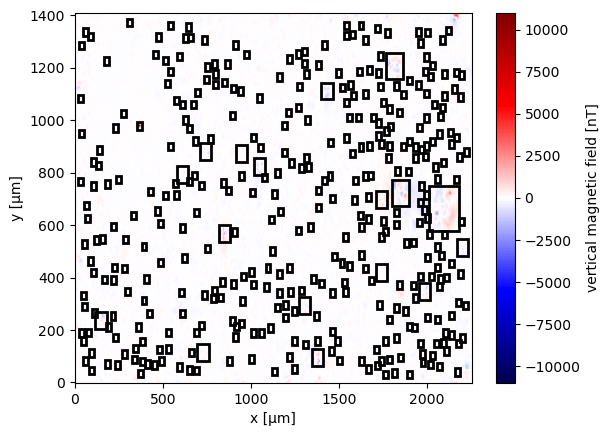

In [25]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

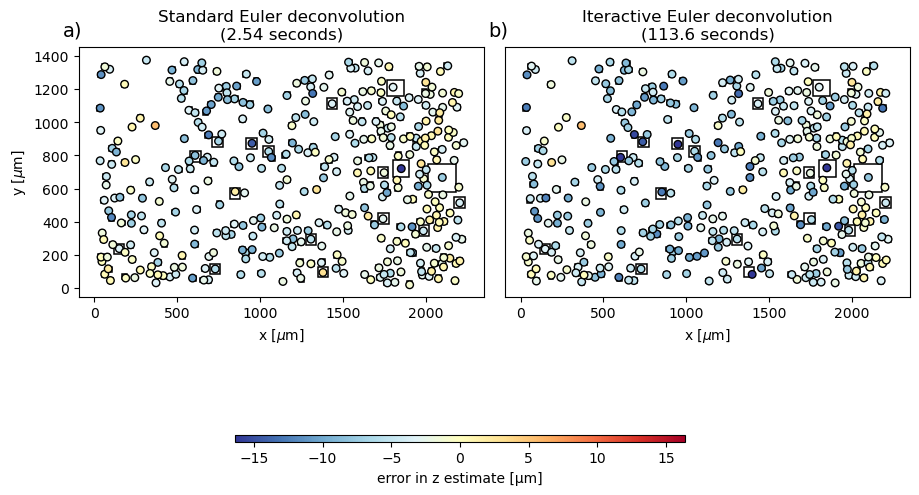

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [27]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

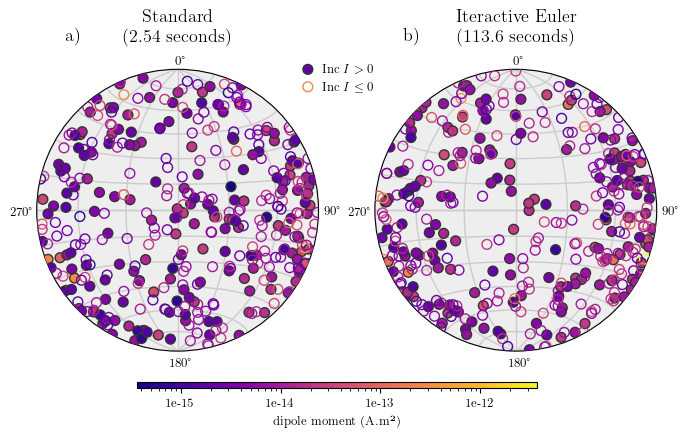

In [28]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

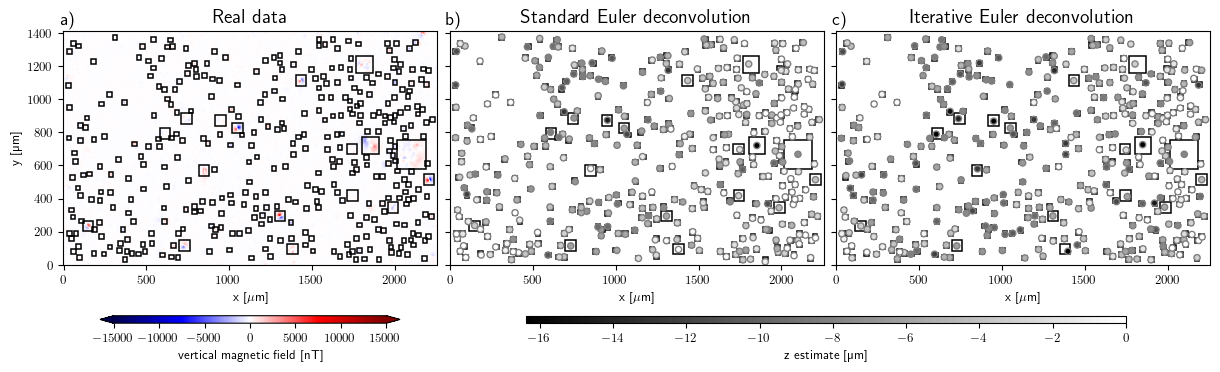

In [29]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


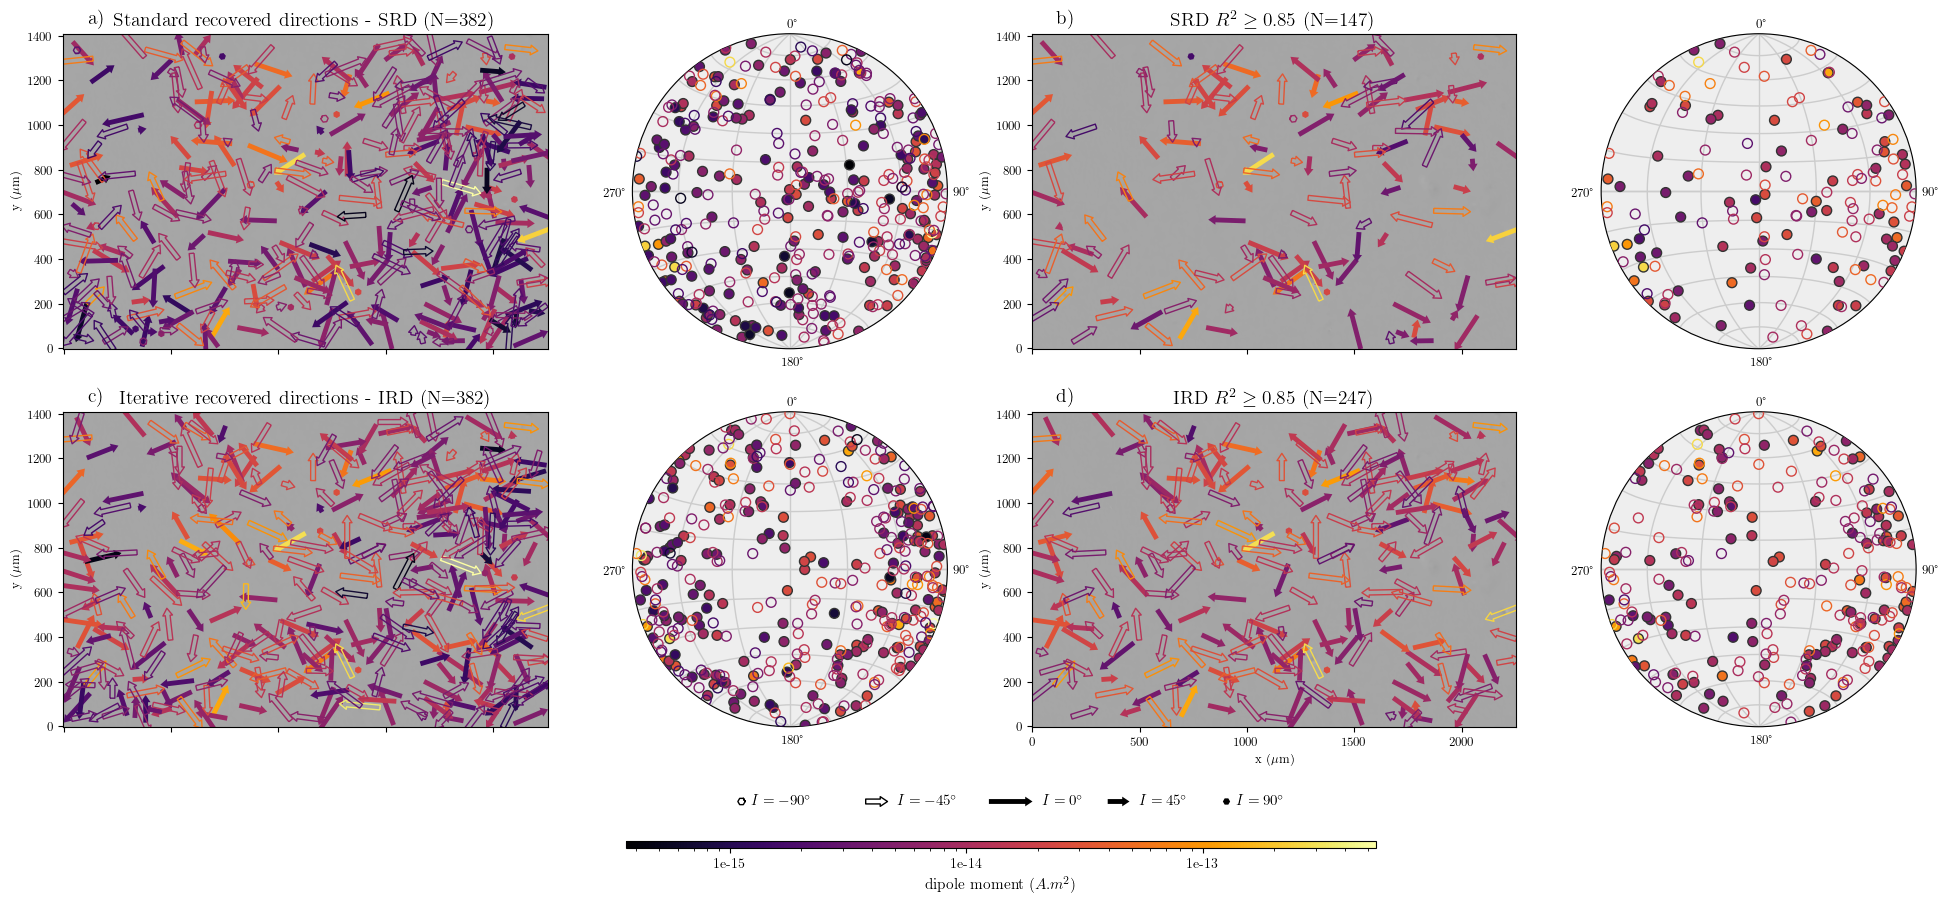

In [30]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

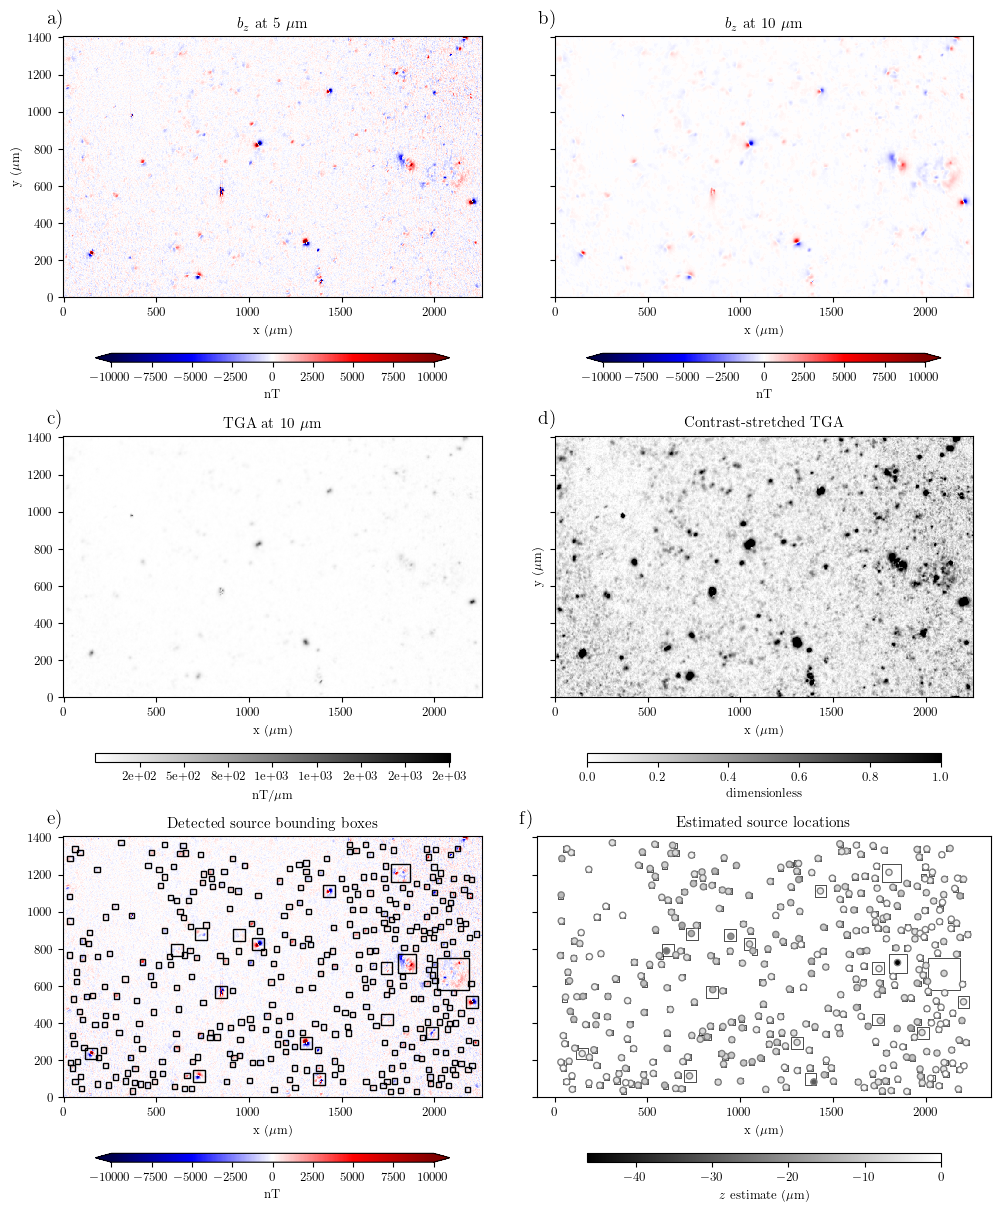

In [31]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [32]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [33]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 2.735 -40.48 -74.17 -78.07 ... 98.9 76.11 54.93
    tga      (y, x) float64 5MB 22.77 21.93 25.02 14.17 ... 20.98 16.2 17.44
    x_deriv  (y, x) float64 5MB -18.39 -16.36 -7.998 ... -8.314 -9.355 -9.012
    y_deriv  (y, x) float64 5MB -11.83 -14.1 -14.0 -12.71 ... 11.81 5.45 -2.807
    z_deriv  (y, x) float64 5MB -6.357 3.788 19.14 ... -15.21 -12.06 -14.66

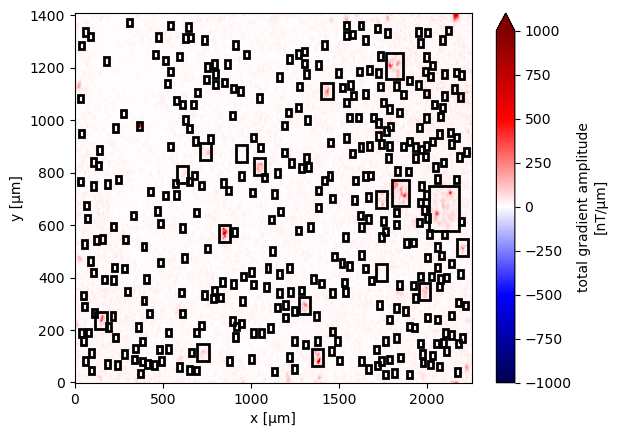

In [34]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [35]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [36]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.1,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [37]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

547 potential sources detected within 1.2816 seconds


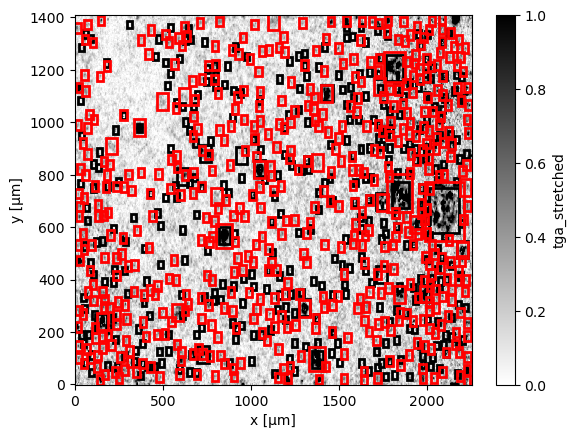

In [38]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[  7.46522369  44.23477631 453.96522369 490.73477631]
[   5.11522369   41.88477631 1114.31522369 1151.08477631]
[1438.61522369 1475.38477631 1365.76522369 1402.53477631]
[1760.56522369 1797.33477631 1370.46522369 1407.23477631]
[1.37046522e+03 1.40723478e+03 4.15223689e-01 3.71847763e+01]
[583.21522369 619.98477631  73.26522369 110.03477631]
[2209.41522369 2246.18477631   35.66522369   72.43477631]
[1189.51522369 1226.28477631    5.11522369   41.88477631]
[124.96522369 161.73477631  -1.93477631  34.83477631]
[1960.31522369 1997.08477631    5.11522369   41.88477631]
[2214.11522369 2250.88477631  216.61522369  253.38477631]
[2216.46522369 2253.23477631  940.41522369  977.18477631]
[2209.41522369 2246.18477631 1114.31522369 1151.08477631]
[1701.81522369 1738.58477631    5.11522369   41.88477631]
[2218.81522369 2255.58477631 1048.51522369 1085.28477631]
[ 129.66522369  166.43477631 1370.46522369 1407.23477631]
[  5.11522369  41.88477631 623.16522369 659.93477631]
[

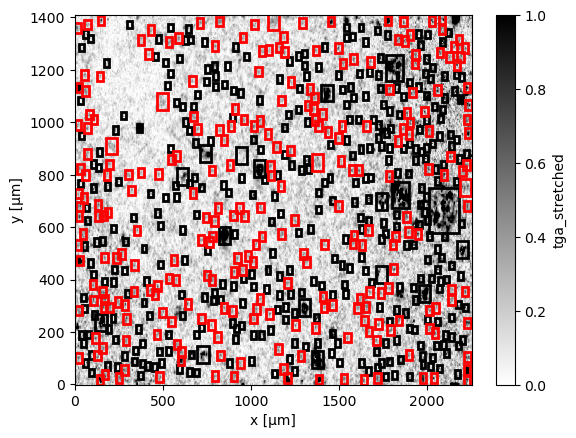

In [40]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [41]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 26.42890083 471.76601465  -4.73816776]

[-1.40656902e-14  1.65925656e-14 -1.91751076e-15]

(5.0377508347125, -40.288290543475256, 2.183652265043466e-14)

0.9836576498030433

[  22.50981389 1132.62915767   -3.95787334]

[ 4.29137230e-15  2.23103892e-14 -3.80830316e-15]

(9.515665610803017, 10.887787690971674, 2.3036330365664946e-14)

0.9651045904969684

[1460.05344321 1384.17647051   -4.8660264 ]

[ 8.66477726e-15  3.70104679e-15 -5.63526048e-15]

(30.883186587364797, 66.87088009374608, 1.0978719092474235e-14)

0.9743971594442464

[1779.30655829 1389.03487057   -2.82838825]

[ 7.20956271e-15 -1.20218346e-14 -3.26771820e-15]

(13.121882647509825, 149.04864372823576, 1.4393758475406057e-14)

0.9712222758420228

[1388.87471617   19.91572488   -3.10796408]

[ 5.72177118e-16 -6.47747763e-15  7.96402514e-15]

(-50.768046212793536, 174.9519757755629, 1.0281575728906344e-14)

0.9271721983747356

[597.11296447  88.76349189  -5.80668077]

[1.00441335e-14 7.93222860e-15 7.14426347e-15]

(-29.170492220621366, 51.70052716994846, 1.465760446527924e-14)

0.9064500506131035

[2227.21952857   53.06568579   -7.54181722]

[-9.09178274e-15 -4.37289973e-14 -1.97345662e-14]

(23.83793196612863, -168.25485015203986, 4.882969205031012e-14)

0.9877050189266475

[1212.45604756   11.08883948   -2.79590512]

(-20.508159488637112, 148.89614954370595, 1.2572935857585496e-14)

0.7154773517463449

[1.44340330e+02 1.71932679e+01 8.05447655e-02]

[-1.62433546e-15  3.26237062e-15  1.10539949e-15]

(-16.873387312916844, -26.468729258771567, 3.808337668748945e-15)

0.882096591209391

[1972.96138668   23.0417693    -9.57398677]

[1.75934692e-14 1.23420491e-15 1.44835135e-14]

(-39.393325098450084, 85.9872000079136, 2.2821603504429223e-14)

0.8580794982458796

piorou

[2239.87166721  233.52061493   -3.83094617]

[ 9.90770990e-15  2.09210973e-15 -1.65273819e-16]

(0.9350659555061046, 78.07659254480312, 1.0127534450215429e-14)

0.8611199888249732

piorou

[2.23725647e+03 9.61961826e+02 3.18665586e-01]

[ 5.98336639e-16 -1.97999043e-15 -8.74042195e-16]

(22.907206769332674, 163.18561973185555, 2.2455107630728415e-15)

0.4726075043019585

[2230.32976452 1131.59793929    2.30488748]

[ 2.09310192e-16 -4.14963784e-16 -7.51285667e-16]

(58.25802697187003, 153.23335212125968, 8.834228048927894e-16)

0.5802346154866844

[1726.71360645   19.24868545   -9.05529144]

[ 1.03251373e-14 -1.05389940e-14 -6.21954509e-15]

(22.857921946765345, 135.58725944532938, 1.601129592930434e-14)

0.8714943289659014

piorou

[2.23313105e+03 1.07034104e+03 1.71190448e+00]

[-8.89689379e-16 -1.50147735e-16 -4.65222883e-16]

(27.276251990517324, -99.5792151886269, 1.0151472136061434e-15)

0.2641245201105281

[ 143.81435352 1387.27535065   -1.41708601]

[ 1.75856780e-15 -3.78474919e-16  1.01318201e-15]

(-29.39011389428122, 102.14580190326414, 2.064543957402806e-15)

0.7557509666524991

[ 18.24572703 640.27822452  -1.43665502]

[-2.77450553e-15  8.08500430e-16  4.53424186e-16]

(-8.916971732999347, -73.75369613097166, 2.925260223737393e-15)

0.7002455206481344

[ 820.84718509 1385.6837594    -9.97587851]

[ 4.93259563e-15 -5.13283254e-15  1.04785110e-14]

(-55.809157572311264, 136.13966503680535, 1.266789892014657e-14)

0.8481038497896524

[  14.16392786 1356.35761009   -8.41727316]

[2.69632305e-15 8.38123888e-15 6.21925879e-15]

(-35.23702035427263, 17.83346954310851, 1.0779355409775075e-14)

0.9346306571153108

[ 27.23595902 680.62217434   2.48470447]

[-6.52251527e-16 -2.32167376e-16 -1.21862840e-16]

(9.982721798457973, -109.59306563528106, 7.029824296684543e-16)

0.4036141739113249

[249.35124262  23.01123561  -0.99747769]

[2.34094914e-15 6.64074957e-16 3.07657627e-16]

(-7.205980048111897, 74.16254571821476, 2.4526906972701952e-15)

0.730014677374857

[ 20.5305251  283.53878213  -4.94948204]

[ 5.66382765e-15  1.78443153e-15 -9.64185103e-16]

(9.222506945636587, 72.51257423454057, 6.016044580454255e-15)

0.8053003697043329

piorou

[ 2.03201936e+03  1.38623986e+03 -1.83356054e-01]

[1.07443941e-15 1.12366163e-15 2.31335333e-16]

(-8.463464292913562, 43.71718627211586, 1.5717988173962347e-15)

0.29009460757422467

[ 2.09043969e+03  1.39391269e+03 -1.67172427e+00]

[ 2.60745583e-15 -3.42674589e-16  1.51018474e-15]

(-29.866236570733097, 97.48696469938399, 3.0326407184204364e-15)

0.6909082732929891

[ 1.53237397e+03  2.29454214e+01 -6.79625089e-02]

[ 1.06631424e-15  7.08002620e-17 -9.28086807e-16]

(40.97290143578974, 86.20129738119464, 1.4154094313181623e-15)

0.75356233311645

[2.08108424e+03 1.27171001e+03 1.28945727e-01]

[-1.57082025e-15 -5.03084297e-16  7.15342999e-16]

(-23.446134489398826, -107.75862717986992, 1.797855855663353e-15)

0.5818093465694716

[ 594.55681912 1313.42065904   -9.88650802]

[-7.98351265e-15  9.29771124e-15  3.50662913e-15]

(-15.96792885618803, -40.65115422071798, 1.2746778275472175e-14)

0.6337216354539478

[20.18014441 96.96999383 -4.63812131]

[-1.22415375e-15  4.52008131e-15  2.03381404e-15]

(-23.475556429476704, -15.153655429860116, 5.105495759527017e-15)

0.7963202116483732

[1840.29259211  247.42676243   -7.00648903]

[-7.03839750e-15 -5.20973256e-15 -1.88926906e-15]

(12.174973059529622, -126.50837542972882, 8.958219146228116e-15)

0.8590271568705709

[  60.23185257 1116.02497177  -11.56557669]

[-1.30462093e-14  1.86095719e-14  1.04117686e-15]

(-2.6230110724614697, -35.03231233939973, 2.275090756461335e-14)

0.9276752154779166

[284.05287441  54.19960225  -4.67375378]

[ 5.98758578e-15  2.09095234e-16 -2.02796994e-15]

(18.700416659404606, 87.9999605121739, 6.3251534603437674e-15)

0.902083604289222

[1225.57091511  892.93467254   -6.03148494]

[3.91789056e-15 5.56152291e-15 3.52783829e-16]

(-2.9685467122695224, 35.16330248633562, 6.812111267835973e-15)

0.8912220883641028

[1057.31231176  673.42378752   -7.49593372]

[ 7.51350733e-15 -3.89200982e-15 -9.81680811e-16]

(6.617556174698535, 117.38423493878801, 8.518464071850322e-15)

0.9791710070528337

[782.9907578  401.00924452  -7.02312756]

[-3.98066124e-15 -8.77598894e-15  1.90200292e-15]

(-11.165147057094938, -155.60164551518082, 9.822487514712459e-15)

0.934083298062206

piorou

[2017.54867311  217.70850089   -2.81782354]

[-3.37894731e-15 -5.56758354e-16 -9.61411876e-16]

(15.681789542876619, -99.3567078275249, 3.5569056207952874e-15)

0.5750731301651041

[289.45847921 245.88077022  -3.22690781]

[ 2.56303223e-15  3.07273966e-15 -2.15339333e-16]

(3.0804905226575903, 39.83214592236953, 4.007147896752205e-15)

0.6825969430029293

[2216.59351049  353.89375318    2.78868467]

[-5.57387598e-16 -9.05090395e-17 -9.73435366e-17]

(9.780780530041458, -99.22323170073713, 5.73017089637772e-16)

0.4616198760564739

[ 542.94603778 1310.72473549   -2.95101918]

[ 3.12324809e-15 -1.44403242e-15  1.92379218e-16]

(-3.2000349177809473, 114.8134408239419, 3.4462904748064835e-15)

0.6063148320303713

[1370.62353254 1274.70835117   -3.89043295]

[-3.17001460e-15  6.99253113e-16 -9.15685449e-16]

(15.752560036335087, -77.56069330442077, 3.372895986759098e-15)

0.822915719745348

[187.15690187 657.41833431  -3.04826729]

[ 1.30347755e-16 -2.23232596e-15  2.21226293e-15]

(-44.692614524151566, 176.65823635520945, 3.1455328631950897e-15)

0.8307843555384434

piorou

[ 56.92615511 807.99422628  -2.50407841]

[-1.43651010e-16  3.17172712e-15  4.66997333e-16]

(-8.367453429406925, -2.5932167112509026, 3.2091392994964118e-15)

0.7116408563382901

[ 674.58766638 1023.05058796  -10.21742392]

[-1.21433288e-14  5.80417882e-15  6.07802525e-15]

(-24.30347430170084, -64.45347680609332, 1.476791508574272e-14)

0.9262764046252079

[2.06340063e+03 1.12370378e+03 1.55274983e+00]

[7.31498549e-16 8.36942626e-16 9.78979614e-18]

(-0.5046062084487702, 41.15387341184731, 1.1116019635896469e-15)

0.44659406773091825

[1190.23193813 1270.66517689   -4.14346137]

[ 1.79026934e-15  3.33432715e-15 -1.00188927e-15]

(14.827855246015591, 28.232272694353284, 3.914918131472671e-15)

0.8506926445774392

piorou

[1.90815040e+03 1.00199910e+03 6.62875486e-01]

[-1.24154657e-16  8.56478510e-16 -1.18749884e-16]

(7.813039778323475, -8.24811195676416, 8.735395537931723e-16)

0.1495497594100389

[580.70438576 150.57255306  -5.78260352]

[-2.43898379e-15  5.71147363e-15 -2.45438485e-16]

(2.2631687156872733, -23.12404801846077, 6.215288646180383e-15)

0.7792081262702824

piorou

[2.23352459e+03 1.06563154e+02 2.88730784e-01]

[-8.88865143e-17 -6.80076316e-16 -7.26510475e-16]

(46.64859657106798, -172.5536061957353, 9.99110643821871e-16)

0.19203586601834932

[1368.49468252 1009.67277378   -3.72101078]

[-2.07640482e-15 -1.83014304e-15  1.93795614e-15]

(-34.9986250177126, -131.39294959709375, 3.378839228294813e-15)

0.7800214338836171

[758.95496481 544.34655332  -6.91422019]

[ 5.24235477e-15 -3.68809863e-15  3.00465501e-15]

(-25.11560035255707, 125.12713247262252, 7.079004645016484e-15)

0.7850824127115068

piorou

[963.08538902 640.50446753  -5.50048992]

[-4.44248720e-16  6.85900857e-16  3.37620519e-15]

(-76.39341645072302, -32.930585038194224, 3.473698087324219e-15)

0.6163145822643461

[293.38096695 165.1882919    0.47076537]

[ 8.65923665e-16  8.25189228e-16 -3.47741814e-16]

(16.210149608874136, 46.37983696462393, 1.2456666587809644e-15)

0.5648679857124324

[260.15432581 499.75966821 -13.58932368]

[ 2.55977292e-14 -5.97294904e-15 -1.41050184e-15]

(3.0716103041493823, 103.13433127037311, 2.632317187921057e-14)

0.9135333552079695

piorou

[1.83656691e+03 1.32177591e+03 3.56666208e-01]

[-7.34513176e-16  8.54238033e-16 -1.20038142e-16]

(6.081852984890955, -40.69045929772961, 1.132978984027021e-15)

0.13851976248711984

[1991.10917777 1051.92752935   -7.29912889]

[-1.31321971e-15  5.78117816e-15 -1.96577997e-15]

(18.34469051777069, -12.797816013797728, 6.245867258401566e-15)

0.474901983894116

[1516.16024621  986.21372548   -6.60718008]

[ 4.89051244e-15 -8.43387507e-16  2.85481028e-15]

(-29.909802317195098, 99.78463368013622, 5.7252385215150935e-15)

0.8968575401105852

[1.79568989e+03 2.07217646e+02 7.88462546e-01]

[-1.07562119e-15 -2.46344328e-16 -5.56630901e-17]

(2.8877618882368385, -102.89970590416723, 1.1048732267444935e-15)

0.7358775351894635

[749.58316242 414.47339805  -3.74251001]

[-2.22288262e-15  3.91844195e-15  2.93343633e-16]

(-3.725528469093688, -29.5656944842236, 4.514581372227461e-15)

0.8745655513930338

[2170.54524513 1222.89672436   -2.22551711]

[ 4.77707556e-16  2.44831172e-15 -1.07439519e-15]

(23.301976416454224, 11.040674075208702, 2.7160191121646052e-15)

0.8262612286545818

[ 960.84834515 1016.72934598   -9.91399392]

[ 2.95730835e-15 -1.01915687e-14  3.46831557e-15]

(-18.098983577737844, 163.81874848305173, 1.1164361029807364e-14)

0.8067454974561179

[ 72.92401758 980.44130628  -7.32626348]

[-2.92302637e-15 -2.72602311e-15  4.19126808e-15]

(-46.359745585205104, -133.00269361269304, 5.791546711027224e-15)

0.8979473011543345

[1879.4049008   639.63310636   -7.72139361]

[-1.16661642e-15 -7.49795285e-15 -3.00156654e-15]

(21.58171020413948, -171.1561844589589, 8.160250767462544e-15)

0.691324935630946

piorou

[2132.77173411  871.8011111     2.58380675]

[-4.27126606e-16  3.05674650e-17  4.92848589e-18]

(-0.6594031964203864, -85.90658624138794, 4.2824735515176297e-16)

0.27524278722545614

[1061.44409985  565.43991001   -7.2963442 ]

[8.06195512e-15 3.36417914e-16 1.33549971e-15]

(-9.397858680898988, 87.61048655092122, 8.178744205234551e-15)

0.8830804982830633

[164.29328257 325.46175068  -3.94822103]

[ 4.92072402e-15 -9.13473606e-16  5.46851297e-16]

(-6.235714808796654, 100.51656184315347, 5.034580938690447e-15)

0.8536850633402158

piorou

[1.95375466e+02 8.36946242e+02 2.40626746e-02]

[ 4.98014782e-16 -3.48929054e-17 -5.94808786e-16]

(49.99254942774722, 94.00782171012268, 7.765524642659443e-16)

0.3394058741400301

piorou

[781.84400562 817.81090957  -3.29049275]

[-1.56102555e-16 -7.46399473e-16  2.05586989e-15]

(-69.64953750748997, -168.1873803012478, 2.1927337228671455e-15)

0.6758938689110177

[952.9320725  439.00586414  -7.22133732]

[ 7.39285430e-15 -3.25576901e-15 -7.92098021e-16]

(5.600293123709482, 113.76840689800588, 8.116757098382693e-15)

0.9095141957514536

piorou

[ 1.81054624e+03  4.41012008e+02 -1.04270747e+00]

[-2.36745331e-16 -1.18056586e-17 -1.62430838e-15]

(81.69728749040632, -92.85477466833706, 1.6415131563461268e-15)

0.41649994203051044

piorou

[ 1.10421532e+03  2.64739688e+02 -5.53918527e-02]

[7.85927123e-16 1.07327695e-15 3.42364187e-16]

(-14.432733012012458, 36.2141507945337, 1.3736149724303536e-15)

0.7320953203624354

[1356.43664407 1051.57790839   -7.94693029]

[ 4.57179741e-15 -2.80270257e-15 -4.98260061e-15]

(42.89685956225288, 121.510034832546, 7.320026103657654e-15)

0.8594195389299824

piorou

[1.04277462e+02 1.01868821e+03 6.02866604e-01]

[5.03145222e-16 2.06864074e-16 5.70460279e-17]

(-5.986267750365321, 67.6503834201799, 5.469937007015881e-16)

0.2010068097100417

[134.61892802 114.92467612   2.31674805]

[1.97056631e-16 5.37081797e-16 1.35376945e-16]

(-13.31331171766183, 20.148211221237222, 5.878903722325415e-16)

0.4472471967106596

[1.88755347e+03 1.03041558e+03 3.06993972e-01]

[ 6.86701947e-16 -1.15146248e-15 -8.98132986e-17]

(3.832564119086343, 149.18926101665642, 1.3436859169255084e-15)

0.5664619546483989

[1031.85946599  285.06959055   -5.56295055]

[ 1.58589559e-15 -6.12336261e-15 -7.01384474e-16]

(6.32733102515888, 165.47994986083907, 6.364163314041333e-15)

0.8911234803079032

[1527.93811957 1224.57624526   -9.88625332]

[ 1.15651458e-14 -2.07658652e-16 -3.34332898e-15]

(16.12141098974689, 91.02866718570525, 1.2040496985174393e-14)

0.8348201414611343

[1064.67449143 1275.99027047   -7.73350721]

[-8.59383345e-15 -3.17930582e-15  7.84479759e-16]

(-4.893339847409145, -110.30205434188763, 9.196595419046364e-15)

0.9454572144945959

[ 3.39330796e+02  4.57399066e+02 -3.76891934e-01]

[ 4.47590139e-16  1.09418193e-15 -4.99938921e-16]

(22.923138429455136, 22.247689551320207, 1.2835536410523748e-15)

0.7257599077884131

[1115.68015193  838.93461606   -6.85737009]

[ 7.19743556e-16 -7.28418478e-15  2.46599320e-16]

(-1.9295655913193965, 174.35697420777277, 7.323809792257397e-15)

0.6673879200305948

piorou

[ 1.15475703e+03  1.32168836e+02 -6.53196994e-01]

[ 6.47131868e-17 -1.99733570e-16 -7.88562621e-16]

(75.09082845550377, 162.04780286446785, 8.160344987044864e-16)

0.29094232673628584

piorou

[2.12832352e+03 1.24581260e+03 6.40882963e-01]

[ 2.52380772e-16  9.65574892e-16 -9.08016717e-17]

(5.198595274937583, 14.648186585105664, 1.0021356541541626e-15)

0.2530383739228421

[1361.0249626  1097.93716294  -10.04561467]

[-1.40400139e-14  8.67458143e-15 -1.22962101e-15]

(4.261007552710652, -58.290275949396154, 1.6549390387908607e-14)

0.9185801897860647

piorou

[ 1.02335923e+03  9.80136541e+02 -5.90684163e-01]

[-1.52407442e-15  3.27954760e-16  4.40394330e-16]

(-15.774579210066118, -77.85610358455787, 1.6199704719253587e-15)

0.4169243935895538

piorou

[1.91781758e+03 1.11764835e+03 2.74332514e-01]

[1.04765873e-15 3.94692669e-16 1.94432155e-16]

(-9.852366417547175, 69.35671056727108, 1.1362988085654828e-15)

0.2597812041522084

[1132.56375768 1384.75379448  -13.76547027]

[-3.39858642e-14 -1.86155211e-14 -5.49397517e-16]

(0.8122813527894419, -118.7114182548583, 3.875407624573869e-14)

0.9098732283007906

[902.91954947 426.75076862  -6.94807398]

[-4.63281337e-15 -4.91372193e-15 -1.13601364e-15]

(9.548618157225324, -136.68545255014544, 6.848222386599922e-15)

0.8428730581576076

[1587.14274394 1236.4416816    -6.7991436 ]

[ 2.99271436e-15 -5.50677147e-15 -2.77504487e-15]

(23.882387356691417, 151.4776542127406, 6.854323106466953e-15)

0.7994891514098607

[ 958.79658306 1323.80471123   -7.85389588]

[ 8.34935013e-15  2.21113399e-16 -7.31358395e-16]

(5.004280733245576, 88.48300719421134, 8.384236626184509e-15)

0.8885136985533513

[467.45488278 192.06851784  -0.81949559]

[-8.52370912e-16 -1.39228760e-15  3.74616321e-17]

(-1.3145721588127754, -148.52465926989333, 1.6329128261600596e-15)

0.6199501669320244

[2233.075605     18.07012402   -5.07251283]

[-2.56830003e-15 -2.96344308e-15  3.75840676e-15]

(-43.78343142308438, -139.08580783071093, 5.431738327301303e-15)

0.65422414848504

[2203.14172305  806.39622582   -4.79977717]

[ 1.36038661e-15 -3.21891398e-15 -2.52343868e-15]

(35.833110889254044, 157.0899697194692, 4.310429415316133e-15)

0.553409887125982

[ 1.49243672e+03  1.27716758e+03 -5.65298066e-01]

[6.64344468e-16 1.59115787e-15 5.40042035e-16]

(-17.390494288199516, 22.661642012571313, 1.8068708661313338e-15)

0.5073249628755151

[ 1.87661946e+03  1.31225161e+03 -2.74515246e-01]

[1.57212414e-15 1.79104760e-16 8.16599936e-17]

(-2.954335342247127, 83.50058141885118, 1.5843993165385876e-15)

0.7310254769707001

[1713.29874537  161.18527802   -3.50482768]

[7.80512383e-16 3.14223662e-15 7.17101924e-16]

(-12.488462331529185, 13.949600721884728, 3.3161854141362825e-15)

0.8313384198633937

[1615.05312983  818.63280234   -4.78111239]

[-1.71842319e-15 -2.66315201e-15  3.15521169e-15]

(-44.87109432656031, -147.16749951554658, 4.472216194754542e-15)

0.8338378692141648

[1172.26545066  757.44004827   -4.44742743]

[-3.37815965e-15  4.89694965e-16  1.58350792e-15]

(-24.886586965726735, -81.75190821190654, 3.7628793599840566e-15)

0.9315825961395597

[1671.25980032  358.5268552    -4.06604778]

[ 2.55651443e-15 -1.97336884e-15  8.74812667e-16]

(-15.156459091779181, 127.66448519791571, 3.3459300371305625e-15)

0.663235153864749

[882.86381448 985.06914836  -4.47671016]

[3.16610451e-15 2.89096713e-15 1.29903134e-15]

(-16.856138520469887, 47.60082468365402, 4.479887400151044e-15)

0.8580254288640933

[845.32564327 929.64195472  -9.62948456]

[ 2.22643495e-15 -8.26388783e-15 -5.29928269e-15]

(31.76494841941582, 164.92154333010143, 1.0066342519333757e-14)

0.8548996534723031

[ 1.17245177e+03  5.73921071e+02 -1.08986413e+00]

[-1.36164646e-15 -1.48960512e-15 -1.71928014e-16]

(4.869277357322155, -137.56959973210024, 2.0254786442851384e-15)

0.46622874130551706

piorou

[ 2.14223410e+03  3.21587970e+02 -8.02852716e-01]

[-1.48338370e-15 -1.64843037e-15 -6.88366699e-16]

(17.24490014273204, -138.0166980860602, 2.321981607523482e-15)

0.6741836897227473

[ 1.55480583e+02  1.34413410e+02 -1.87586713e-02]

[ 1.50908927e-15  2.34608546e-16 -1.92210954e-16]

(7.173358679482116, 81.16332619456885, 1.5392649723891195e-15)

0.5738075280181266

[156.94458749 296.50334499  -0.8873138 ]

[ 7.34959433e-16 -1.37165043e-15  8.61595095e-16]

(-28.972089343462553, 151.8166486067733, 1.7787457304977988e-15)

0.6387678542925113

[1656.43044691  297.94222634  -10.97431328]

[ 1.72736202e-14  6.33897396e-15 -7.59535834e-15]

(22.43038880842447, 69.8481630092166, 1.9906029587805696e-14)

0.9446332065562986

piorou

[ 2.03279269e+03  2.78773709e+01 -1.86149606e-01]

[ 1.56928712e-15 -2.47703253e-17  4.09263096e-16]

(-14.61516066228415, 90.90430694671576, 1.6219654527462935e-15)

0.3996994840108855

[1495.0743087   940.66497073   -3.74935692]

[-2.67742011e-15  1.22382321e-15 -1.45711910e-15]

(26.333964900404062, -65.43531157312916, 3.2847401348978892e-15)

0.902390461412755

piorou

[2.08231329e+03 1.35607639e+03 5.38024128e-01]

[-7.74623585e-17 -6.33608758e-16  8.58725624e-16]

(-53.375049917793866, -173.02984656703973, 1.0699860615557039e-15)

0.3476031983060398

[ 1.78752941e+03  1.11434377e+03 -1.29049946e+00]

[8.52475523e-16 3.89613919e-16 1.14481903e-15]

(-50.69199869512115, 65.43778649759221, 1.4795688988462816e-15)

0.4926764663138934

[1103.76454655  956.66908173   -4.1034159 ]

[ 3.84692753e-15  6.05018046e-16 -1.74842729e-16]

(2.5707443516391724, 81.06213000441933, 3.898136505208107e-15)

0.8182685884956746

piorou

[ 2.22573580e+03  1.00635344e+03 -1.29996130e-01]

[5.06348657e-16 1.01463520e-15 9.63664301e-16]

(-40.35852862788904, 26.52126204415249, 1.4881271553015942e-15)

0.32101088004543576

[ 3.20930272e+02  7.38552532e+02 -4.91361094e-01]

[-1.26283315e-15 -3.82415540e-16 -9.57611587e-17]

(4.151004550391669, -106.84754514292156, 1.3229359057883339e-15)

0.7514436547347066

piorou

[ 15.40037095 533.31879126  -0.88961191]

[-2.06700530e-16  6.39102657e-16 -7.55804450e-16]

(48.37191713773929, -17.922402934141648, 1.011146715961476e-15)

0.29167515891300344

[1460.87592845  299.39501721   -7.34955313]

[-1.40807984e-15 -5.98157473e-15 -3.29886515e-15]

(28.228277444621487, -166.75357622994778, 6.974556355704462e-15)

0.8784971654785969

[ 794.70043997 1291.39146134   -2.47166822]

[ 2.26231476e-15 -4.66446283e-16  1.01780271e-15]

(-23.779547483473774, 101.65004751847476, 2.524195431942709e-15)

0.7852780605745324

[ 707.11982906 1378.62231863   -8.20485371]

[-7.78936806e-15 -2.28660924e-15 -2.51860733e-15]

(17.236377123312433, -106.35987399270961, 8.499777610734662e-15)

0.6324631529721777

[ 54.57020115 713.260224    -9.35503166]

[1.31877617e-14 4.68830125e-15 1.12176799e-15]

(-4.5823072077690155, 70.42949956704416, 1.4041210395823724e-14)

0.9496376989521098

[1371.54356734  214.06741136   -8.28967422]

[-2.47981467e-15 -7.40697119e-15 -3.06788104e-15]

(21.442965239521005, -161.48972727719624, 8.391936431738436e-15)

0.8693736468378591

[1027.12582014  530.51536127   -2.84457308]

[-1.86193288e-15 -1.80115054e-15  2.58518920e-16]

(-5.698858739120338, -134.04936593543312, 2.6034149458064025e-15)

0.7353580529912495

piorou

[1.49867604e+03 6.84766651e+02 4.60124031e-01]

[-1.24386800e-15 -5.81663796e-17  3.41473600e-16]

(-15.335010240636949, -92.67734358918095, 1.291199110327663e-15)

0.5333835309920716

piorou

[ 2.19675387e+03  1.24596766e+03 -8.50281742e-01]

[9.65105597e-16 1.90495880e-15 1.14070348e-16]

(-3.0576395798003606, 26.868053291575563, 2.138529609287895e-15)

0.49614671218831063

piorou

[2.22483320e+03 7.44575844e+02 3.83214115e-01]

[-6.87169126e-17  1.47125559e-16  3.88261475e-16]

(-67.30391867444672, -25.035540422016137, 4.208502309488795e-16)

-0.046177498800969774

[230.42847531 482.98960921  -5.2357848 ]

[-1.88811922e-15 -3.40517651e-15  2.44375026e-15]

(-32.11363621625718, -150.9922899233789, 4.596970367914955e-15)

0.757986497715541

piorou

[668.91279971 739.18715864  -4.32707026]

[-1.29809422e-15  3.93257976e-15 -2.08574584e-17]

(0.288566122992944, -18.267395023328096, 4.141336400941132e-15)

0.43157083474441993

[ 2.23185198e+03  6.71708354e+02 -2.61259894e-02]

[-1.74465325e-15 -2.09329843e-16 -5.17951544e-16]

(16.42368305614161, -96.84184920928314, 1.831913689121455e-15)

0.5238588715210665

[109.89656972 380.38422095  -4.98338125]

[ 3.02168890e-15  2.39483060e-15 -1.63022185e-15]

(22.91946164623023, 51.601519908058826, 4.186100888647e-15)

0.7034697440708935

[1377.26102915  843.1279747    -8.38327815]

[-3.66881191e-15 -2.62530827e-15  5.45557795e-15]

(-50.41172680779825, -125.58654365610352, 7.079248202013407e-15)

0.4772779707694985

[1054.5916299  1006.36942568   -2.05225453]

[ 2.26256369e-15 -1.48112034e-15 -1.82777230e-16]

(3.8666915547048455, 123.20957614552098, 2.7104094614930225e-15)

0.6176515996848482

[1628.81481516  532.13196854   -1.80888701]

[-1.39089108e-15 -1.96723423e-15  2.29467310e-16]

(-5.440635926260607, -144.73859259259814, 2.42017432193528e-15)

0.6558615042363345

[2.04320084e+03 1.89673803e+02 4.94247036e-01]

[-4.22884665e-16 -1.04488476e-15 -3.11735063e-16]

(15.45894901436669, -157.96588769768093, 1.16952740704539e-15)

0.42627455549280646

[1243.97426531  625.18051855   -9.11887839]

[ 2.60574497e-15 -9.92163085e-15 -3.87691274e-15]

(20.70341550503288, 165.28458182458021, 1.0966271837727316e-14)

0.8668929325034571

[  60.77997918 1177.69156444   -4.82618484]

[ 3.69842088e-15 -8.88334321e-16 -1.49645807e-15]

(21.476210144941017, 103.50618154559119, 4.0874003477882e-15)

0.8584147538041156

[1668.07856938  597.67427431  -10.54011335]

[-6.87058715e-15 -1.28743544e-14  5.37603141e-15]

(-20.223767645350858, -151.91273829269545, 1.5551709972511043e-14)

0.8288618734931198

[797.0089572  627.60294843 -15.30372392]

[ 1.06794014e-14  1.63538769e-14 -1.83000545e-14]

(43.13491035405624, 33.14532213110564, 2.6765479605504292e-14)

0.9313815790774781

[241.67133805 319.38594782  -8.56095871]

[ 6.77878902e-15 -2.29868731e-17  2.54845123e-15]

(-20.603386600694577, 90.19428923945563, 7.242037882196684e-15)

0.5786607258006295

[784.73806098 563.98617309  -3.08389739]

[-1.30373563e-15  3.19428872e-15  4.16623192e-16]

(-6.885513163739607, -22.20262233447248, 3.475166458653216e-15)

0.8109875528703006

[ 1.43781497e+03  9.62370774e+02 -8.41426904e-01]

[-8.78125250e-16  9.52872633e-16  7.15844222e-16]

(-28.9179595042487, -42.66229502972513, 1.4803726424591727e-15)

0.4509771625316964

[1414.44730152  337.83363709   -3.27946373]

[-1.98880209e-15 -1.47254484e-15  1.62955411e-15]

(-33.365223240955196, -126.51691300479798, 2.9629661910040464e-15)

0.7490936971372024

piorou

[927.23475479 470.93867988  -3.25235863]

[-1.10973792e-15 -1.92251871e-15 -2.82864131e-17]

(0.7300614924236098, -150.00511386298547, 2.21999922211382e-15)

0.2046698526147136

[449.55963412 353.98263861   0.94031868]

[-4.44849543e-16  8.19799237e-16 -9.66571267e-17]

(5.916419231676135, -28.48568727200022, 9.37712378959834e-16)

0.37125355626474166

[1587.97794579  565.24145041   -3.16155272]

[-2.68988946e-16 -1.75698915e-15 -1.69138718e-15]

(43.57859793805717, -171.29579953698, 2.4536007242734557e-15)

0.8208332262514081

[1577.91767894  540.57329849   -3.52255546]

[ 1.78870084e-15 -1.03024400e-15  1.90775541e-15]

(-42.744668680962924, 119.94079556904057, 2.810762193164411e-15)

0.7822742760104882

[567.51142522 396.31026565 -11.52772165]

[-1.09155315e-14  6.86886243e-15 -6.24658549e-15]

(25.843121896307387, -57.81885128739308, 1.4330035882464982e-14)

0.9061851109053726

[ 7.17669216e+02  5.51077601e+02 -5.25658060e-02]

[ 1.02060262e-15  4.08780591e-16 -3.91465676e-16]

(19.599014863086744, 68.1724836291357, 1.1670375544904522e-15)

0.7138302426987351

piorou

[ 1.62282148e+03  3.28333505e+02 -1.08400036e+00]

[ 6.43180630e-17 -1.50907743e-15 -4.52986718e-16]

(16.694110351705405, 177.5594860082315, 1.5769110543407223e-15)

0.41422556252080445

piorou

[830.76237419 103.18530129   2.03464439]

[-2.29233313e-16 -4.37324114e-16 -4.82708710e-17]

(5.583580601330037, -152.33770367260936, 4.961152780645542e-16)

0.2416254384721077

[1050.71319714  322.63753678   -3.76847255]

[-3.35013018e-15  1.23155346e-15 -8.55217996e-16]

(13.474170732862305, -69.81588510290723, 3.6703533871627e-15)

0.8343680041070258

[1326.38604238 1064.83890524  -10.62102867]

[-4.39187272e-15  8.68561617e-15 -7.07468267e-15]

(36.01290271528497, -26.823394574062092, 1.2032439861734388e-14)

0.9327208785560529

[1387.44841329  987.49007751   -4.77266089]

[ 3.59506377e-15  5.25668686e-16 -2.61467866e-15]

(35.74047075178689, 81.68118720894726, 4.476310487951835e-15)

0.8353584520195879

piorou

[ 8.00471483e+02  2.92564683e+01 -1.63107352e-01]

[-2.77464175e-16  1.96225656e-16  7.99060711e-16]

(-66.96001335744337, -54.731637973287505, 8.683253401359526e-16)

0.5001960976387256

[ 481.89010782 1097.87175574  -11.51025432]

[ 1.51493518e-14 -4.66568730e-15 -4.57164839e-15]

(16.087770257844596, 107.11775089568289, 1.649762005808837e-14)

0.5935645366862463

[1658.06849404  987.74185992   -7.68590609]

[ 2.57493033e-15 -3.21834732e-15 -2.40866680e-15]

(30.30173146041551, 141.33745108336646, 4.7738560296814664e-15)

0.6470480426315623

[1410.43578016  294.65550539   -4.10788436]

[ 3.16925402e-15 -9.54170532e-17  5.45727980e-16]

(-9.765862635522332, 91.72448894205918, 3.2173116840034966e-15)

0.7154684173575013

piorou

[1.81595349e+03 5.66675113e+02 8.57590646e-01]

[-1.60038949e-16  7.83239121e-17  3.10767093e-16]

(-60.1723565932305, -63.92262848707497, 3.582223984515712e-16)

0.08237445327326454

[ 1.18456207e+03  5.51231777e+01 -3.28041211e-01]

[6.20604540e-16 1.44578690e-15 1.72193239e-16]

(-6.245779336169554, 23.231445972372967, 1.582750850192023e-15)

0.5744540153920696

[1940.42724893  588.16588021  -13.13915247]

[ 1.85543595e-14 -1.68177196e-14 -2.10230062e-14]

(40.01383133671789, 132.18924337369134, 3.269658601495058e-14)

0.8398554976058523

[ 3.71734357e+02  8.03533259e+02 -7.70878025e-01]

[-1.00752909e-15  8.22950129e-17 -1.93225689e-16]

(10.821281763827374, -85.33044471472851, 1.0291858399728821e-15)

0.49800615105920565

[  77.8708024  1026.11361354  -10.453997  ]

[3.16962706e-15 6.01119585e-15 6.84914504e-15]

(-45.22458231642986, 27.802110829670553, 9.648409145965986e-15)

0.9013662114057486

[1046.56840765 1188.65801213  -11.56974816]

[-1.34723880e-15  1.19353592e-14  7.62171234e-15]

(-32.39728419775957, -6.440169739120006, 1.422527153822349e-14)

0.9041831676735592

[ 1.93823942e+03  1.25823909e+03 -1.49866919e+00]

[-1.41106032e-15 -8.14998833e-16  9.09966875e-16]

(-29.180237976829524, -120.00982883821679, 1.8663745668278455e-15)

0.46815082485068116

[532.83368875 401.36933555  -3.85973382]

[-6.68333730e-16  3.59749507e-15  5.13803470e-17]

(-0.8044941296787794, -10.524286818535142, 3.659409878499631e-15)

0.8156509869608073

[1212.29978985  381.57789173  -10.79320621]

[-3.13447025e-15  1.25116322e-14  5.74967512e-15]

(-24.025897734782696, -14.064523205244331, 1.4121777810806376e-14)

0.8128670215352461

[714.12477135 251.11705954  -6.24400066]

[-2.49527574e-15 -4.26007507e-15 -1.67991757e-15]

(18.791705824752356, -149.6409941258753, 5.2150516470752145e-15)

0.8791430159207975

[166.57353688 487.26910142  -1.24484985]

[ 1.48209175e-15 -1.05545353e-15  7.92287842e-16]

(-23.530368472232688, 125.4561044285057, 1.9845145820964806e-15)

0.7525534947418938

[ 910.67815085 1053.98001626   -6.72396675]

[-2.92373506e-15 -4.76759615e-15  1.23985023e-15]

(-12.499808038699593, -148.48123365759338, 5.728475216706637e-15)

0.8676328112716355

[109.52287214 318.97584925  -1.32726425]

[ 1.81053425e-15 -1.41983306e-15 -6.57082070e-16]

(15.938334293632717, 128.1037794311701, 2.3928470570855344e-15)

0.6527651496043618

[1335.59774643 1125.76589457   -5.01841939]

[ 1.79270378e-15 -3.67740251e-15 -1.35990886e-15]

(18.3871620505863, 154.01114336119835, 4.3111979945735346e-15)

0.8162025638275083

[ 1.67492067e+03  2.07767696e+02 -6.88429715e-01]

[-1.08402153e-15 -9.63193338e-16  4.54993256e-16]

(-17.41991582672603, -131.6222775508699, 1.5198233273114468e-15)

0.6682914674271998

[ 72.02741718 880.29592752  -2.91391883]

[1.76752629e-15 2.53436278e-15 2.66498007e-16]

(-4.929540226568552, 34.89285697656898, 3.101316668228752e-15)

0.7868193877144601

[543.73401468 236.00168277  -4.22668092]

[-2.27466625e-15 -1.06801692e-15 -2.01400846e-15]

(38.71082960397256, -115.15131683702747, 3.2204031933685448e-15)

0.7840802877917251

piorou

[2214.8053953  1283.72613355    2.84127785]

[-5.48496642e-16  2.59406540e-16 -3.45843039e-17]

(3.2623105724313772, -64.68861411360845, 6.077305274464781e-16)

0.40999912439915487

[ 432.16124825 1352.28356731   -7.96095204]

[-3.45405967e-15  7.98088294e-15 -7.72442816e-16]

(5.075957009450607, -23.402559094682005, 8.730503345338069e-15)

0.9515239603039718

[304.5367773  798.91043717   1.14922063]

[ 7.30869888e-16 -1.47090068e-16  3.23143392e-16]

(-23.434057766520336, 101.37896960519168, 8.125441117425087e-16)

0.5452704297431086

[1647.57357662  247.08158598   -4.8458058 ]

[ 1.89349639e-15  4.22366654e-15 -1.54203454e-15]

(18.42537725851423, 24.146994896351078, 4.87878654255356e-15)

0.890197755161357

[ 1.58012202e+03  8.16702373e+02 -4.90154516e-01]

[-1.02895087e-15 -3.80537297e-16  8.89003776e-16]

(-39.01952563784829, -110.2959253241222, 1.4120468239969173e-15)

0.6566913284489209

piorou

[2160.02014349 1284.95369021    3.17587438]

[7.32931382e-18 1.08677959e-16 1.63445130e-16]

(-56.319299929725375, 3.8582231598442305, 1.964151935291917e-16)

0.13862789841520806

[642.16830785 306.95589095  -4.33202119]

[ 1.17114784e-15 -1.23560400e-15 -2.69228794e-15]

(57.693204382404126, 136.53409377287215, 3.1853914753370116e-15)

0.8447196151251508

[ 26.28944063 817.4820404   -9.74716578]

[-5.32377612e-15  1.01767571e-14 -1.68230726e-15]

(8.333228552952418, -27.615456027579455, 1.1607718803519723e-14)

0.7429332842326464

[1899.31681183  952.27109707    2.68011139]

[-4.82381715e-16 -9.23675062e-17 -6.92958963e-17]

(8.030873846403207, -100.83990897500813, 4.960098748344264e-16)

0.4057606958117026

[1285.85141793  110.9470706    -3.50255419]

[ 1.03057754e-15  3.51550626e-15 -4.91964120e-16]

(7.648480841762666, 16.338602303169555, 3.696336431206755e-15)

0.6688073242275454

[906.50486396  30.43685203  -7.18191605]

[7.68678863e-15 1.19432331e-15 3.47464019e-15]

(-24.068796735049357, 81.1683698778863, 8.51975656901749e-15)

0.9093013925615262

[425.87955444 358.68822424   2.11191745]

[-5.60816028e-16  9.03279365e-17 -1.45597719e-16]

(14.376233027490262, -80.85022584435262, 5.864063857558253e-16)

0.4911377400922352

[1182.80984688 1330.1529374   -10.53765128]

[ 7.08654959e-15 -1.01295285e-14  2.20502270e-15]

(-10.113301559882647, 145.02362435404055, 1.2557414427477873e-14)

0.8879638009169963

piorou

[1.72454603e+03 2.36468956e+02 3.08632851e-01]

[ 7.38846916e-16 -1.07326858e-16 -4.81494957e-16]

(32.81860060217259, 98.26512533195749, 8.883981164536347e-16)

0.2640468280149997

[2189.5903721  1316.47636878  -16.3046659 ]

[-2.04056814e-16 -2.41097221e-14  1.54013502e-15]

(-3.654971660966253, -179.51507881283436, 2.4159725880793146e-14)

0.7489652122679089

[881.54179792 837.13740212  -1.41303504]

[ 1.55458322e-17 -7.04939377e-16  1.10538988e-15]

(-57.46683886625739, 178.7366768594568, 1.3111323253738574e-15)

0.8232176094242487

[334.50885441 353.85408877  -6.57227092]

[7.31926055e-15 2.73750434e-16 1.88882896e-15]

(-14.46051630739823, 87.85805725441394, 7.564006154140409e-15)

0.8550710257824208

[1287.7671367  1378.59420931   -3.61862748]

[2.39535911e-15 1.98338612e-15 1.03655603e-15]

(-18.433589023218104, 50.37483500891223, 3.2781113664174526e-15)

0.8258167344110001

[462.27487845 378.39366674  -7.58437273]

[-7.00186865e-15  2.07502191e-15 -1.20943189e-15]

(9.403435886768829, -73.49267360986248, 7.402337877237471e-15)

0.745142965045197

piorou

[173.11711765  31.9560618    0.93124077]

[-3.30901635e-18 -6.78437310e-16 -7.22679722e-16]

(46.80826080752389, -179.72054725584454, 9.912386760101216e-16)

0.3690916948256747

[ 1.42100539e+03  5.32653355e+02 -1.26439464e+00]

[ 1.46625148e-15 -7.10967929e-16 -4.69704937e-16]

(16.0793942497412, 115.86819560346922, 1.6958748560776228e-15)

0.6852359673406763

[501.23709225 269.74541459 -13.85365565]

[-1.16263202e-14  6.10765942e-15  5.26182087e-15]

(-21.833874542746468, -62.28568915992896, 1.4147847346621504e-14)

0.6956210952662008

[9.36356139e+02 6.67667538e+02 2.95101910e-01]

[-3.83886557e-17 -9.42085850e-16 -2.57389582e-16]

(15.268910368016398, -177.66656958787013, 9.773683213664858e-16)

0.6029706201339687

piorou

[ 2.09521340e+03  8.03626939e+02 -1.75378999e+00]

[1.54544797e-15 1.87427226e-15 8.10011671e-16]

(-18.440429847693803, 39.507591761303566, 2.560746926484416e-15)

0.3772733340927279

[775.87182458 227.880652    -8.07911134]

[ 4.97089048e-15 -3.30552211e-15  2.72251626e-15]

(-24.515962753231854, 123.6229466010604, 6.561122108764361e-15)

0.8798626180807496

piorou

[ 2.22754788e+03  8.35562484e+02 -1.77870759e-01]

[ 1.12538995e-15 -1.12849371e-15 -6.36955166e-16]

(21.784671709109762, 135.0789003447741, 1.716307805045058e-15)

0.5280670277056386

[4.71017910e+02 8.03968415e+02 3.04443846e-01]

[-8.14919986e-16  2.51371360e-16 -2.32184462e-16]

(15.230124609507543, -72.8570250688446, 8.83850535486557e-16)

0.6071801700826214

[1106.99543854  792.51139671  -11.20648936]

[1.16538153e-14 7.23546294e-15 5.30472955e-15]

(-21.142443763626634, 58.165241461450606, 1.4707259761048285e-14)

0.8287137812120059

[ 371.66346452 1316.5749554    -9.82264046]

[9.75764998e-15 3.79252428e-16 9.80951373e-16]

(-5.736441462515871, 87.77419445440553, 9.814164821934876e-15)

0.8330600431598445

[1417.03072254 1030.95060949   -6.0511282 ]

[-5.53314111e-15 -3.58065162e-15 -1.58623203e-17]

(0.1378986494383399, -122.9080445105752, 6.590672822080199e-15)

0.7870565729653893

[1738.5814562   349.45510569   -5.6210492 ]

[-8.14118355e-16 -3.53098108e-15  2.42303044e-15]

(-33.76973198936673, -167.01652903381827, 4.359093099117203e-15)

0.7422674932928247

[812.45474364 667.4229231   -6.44936407]

[-2.95729208e-15 -5.79777033e-15 -1.08957364e-15]

(9.503727300166224, -152.97505239281764, 6.599006584033149e-15)

0.8405786632470955

[938.63906547  78.13144803 -15.3523624 ]

[ 1.56824035e-14 -1.30517114e-14  1.83618221e-15]

(-5.142504395295935, 129.76898704317284, 2.0485519663666006e-14)

0.7479696139435866

[559.07604386 468.13241519  -5.73092387]

[1.40840522e-15 3.79776327e-15 2.68617323e-15]

(-33.55112560174985, 20.34736135233759, 4.860261078404254e-15)

0.8112325732686437

[130.76459257 685.33312485 -11.38964066]

[9.23276074e-15 9.45105621e-15 5.30174991e-15]

(-21.86421584107685, 44.33060572735711, 1.4236393025411813e-14)

0.6596795648983299

[1299.57640695  492.8353717    -6.2970777 ]

[-4.07349135e-15 -2.64728351e-15 -2.73533749e-15]

(29.38138672151191, -123.01906306729646, 5.575259006389586e-15)

0.8949581367463812

[817.26792669 971.04228714  -9.33403272]

[6.30824426e-15 1.70717484e-17 6.10595291e-15]

(-44.0663337652785, 89.84494310837266, 8.779344961943811e-15)

0.8918226704393587

piorou

[ 1.80630176e+03  5.43596328e+02 -1.12235034e+00]

[ 3.67708369e-16 -1.60673339e-16  5.61786981e-16]

(-54.462102999453144, 113.60333685210205, 6.903839356097501e-16)

0.15482919905165216

[132.92041457 648.28964195  -5.71414157]

[ 4.91173661e-15 -5.25510199e-15  6.05354467e-16]

(-4.810517030866674, 136.9343193376071, 7.218566861189327e-15)

0.7778855611718191

[477.46992359  20.98851448  -6.10481386]

[-4.09703622e-15 -5.87745020e-15  1.14212195e-15]

(-9.057533644374475, -145.12052825258385, 7.254968591323632e-15)

0.7890558267253865

[547.52939409 852.90196673  -7.98025411]

[-7.46526876e-15 -3.96453829e-15 -2.11495128e-15]

(14.047606678880141, -117.97117920422392, 8.713255440368328e-15)

0.885862338543622

[980.21071472 486.92002089  -7.87916669]

[7.86228798e-15 2.16419761e-15 1.26904916e-15]

(-8.845508269182004, 74.60973607112085, 8.25286673820534e-15)

0.9172695561079607

[1149.64356936  903.71774055  -17.61120178]

[-3.97268607e-14  2.06906121e-14  6.79462513e-15]

(-8.625596094921987, -62.48852061055779, 4.530443492418741e-14)

0.972459433420279

piorou

[ 2.08434949e+02  9.15047837e+02 -9.83445730e-02]

[-6.25029236e-16 -1.90518304e-16  5.48040425e-17]

(-4.794319652345046, -106.95200925996346, 6.557150702666974e-16)

-0.024942353202246803

[1320.62018268  471.62860939   -7.45909348]

[ 7.27244242e-15  4.64294224e-15 -1.80553797e-15]

(11.819209244710489, 57.44463573399777, 8.815060903622948e-15)

0.9304228000440424

piorou

[ 1.86894120e+03  1.38070348e+03 -7.97805609e-01]

[-1.49975145e-15  4.17028486e-16  1.51635344e-15]

(-44.24867153176398, -74.46060888454657, 2.173130216986315e-15)

0.5893956350502683

[1514.49057497  854.15910658   -8.14602161]

[-2.87649913e-15  5.20649921e-15  2.25428940e-15]

(-20.75583372378896, -28.91987729289349, 6.36110855018149e-15)

0.7251910658734395

[1168.87544205 1281.17900962   -5.16885178]

[-3.19952171e-15  2.86998645e-15  1.00351806e-15]

(-13.14192857759716, -48.10774103649621, 4.413707045635554e-15)

0.6292376017633245

[ 5.72352105e+02  8.66277685e+02 -7.41430801e-01]

[-9.59813807e-16 -4.16764039e-17 -6.82590168e-16]

(35.393789281957865, -92.48629787781887, 1.1785197509920177e-15)

0.6765515330889007

piorou

[1.90657546e+03 1.33129260e+03 4.70570757e-01]

[-1.30658886e-15 -2.77869033e-16 -2.20365820e-16]

(9.367603683705156, -102.00608332432446, 1.3538636375311801e-15)

0.5934333431921355

[1549.04262724  180.04955626   -7.56703858]

[-4.68235059e-15  3.66983932e-15 -2.23018438e-15]

(20.549807391884492, -51.912069575717126, 6.3534124707846314e-15)

0.7816555353458554

[1179.11549081 1083.9528865    -5.00421491]

[-2.97076983e-15 -2.02268830e-15  1.68544038e-15]

(-25.124755145326816, -124.24951395342397, 3.9695655452732925e-15)

0.7938006616892981

[163.32253146 644.1697447   -1.76579265]

[-2.29693719e-15  5.50038678e-16  9.45824965e-16]

(-21.823869453547065, -76.53319233935869, 2.5442185171736818e-15)

0.846603460441689

piorou

[1859.0339764   981.65668785    1.94950842]

[ 1.75094574e-16  5.04554025e-17 -1.46755079e-16]

(38.84714676369228, 73.92508929826651, 2.339677559152694e-16)

-0.017272975713624072

[1795.47719863  784.79128273   -4.01590995]

[-5.24564960e-15  1.57136935e-15  8.86926992e-16]

(-9.200167526258065, -73.3240619390652, 5.547312936981906e-15)

0.6043096137805923

[ 46.47003128 575.81147667 -10.54651877]

[-3.87418272e-15  1.12304866e-14  2.52594356e-15]

(-12.003613267140295, -19.03290631349592, 1.2145514063439559e-14)

0.7194642604346666

[751.45297673 639.07243371  -5.22002857]

[ 3.65118302e-15  8.43726653e-16 -1.51325779e-15]

(21.989610636018828, 76.9883108431386, 4.041405852332692e-15)

0.7719319764015546

[1016.41486218 1368.88588022   -8.83769599]

[5.64297406e-15 3.83937659e-15 4.33867769e-15]

(-32.44333993067441, 55.76934364910025, 8.08752699727108e-15)

0.7977967616288195

[691.03533178 967.81633354 -11.93356795]

[-9.63104645e-15 -1.04339057e-14 -4.27129276e-15]

(16.741686996789767, -137.2913546348544, 1.4827925880361575e-14)

0.8713789002628711

[1643.17080421   13.2607723     2.28290703]

[-3.92400207e-16  4.16754733e-16  2.11222454e-16]

(-20.25407766173447, -43.275990949722484, 6.101453556603264e-16)

0.5186942891802993

[182.3839588  801.98527299   1.2243653 ]

[-7.23474870e-16 -1.61069428e-16 -3.49831748e-17]

(2.702286844549242, -102.55123757250146, 7.420128509679978e-16)

0.6035353160940568

[1676.16543898 1227.88862348   -3.09241084]

[4.24177801e-16 2.37446728e-15 9.19791982e-16]

(-20.873392600840052, 10.128548389132748, 2.581479998289449e-15)

0.7053046665699351

[1250.15195699  226.53015082    2.66067285]

[-2.11188139e-16  2.99529137e-16 -1.32390290e-16]

(19.861450856367295, -35.18640457202477, 3.8967335439689204e-16)

0.34073179266455733

[2.13995561e+03 3.59176126e+02 2.84958732e-01]

[1.19123372e-15 1.48843590e-16 2.63753724e-17]

(-1.25860779948844, 82.87785472325899, 1.200786347039224e-15)

0.5438379720981572

[2016.26285306  825.40098591   -6.95638116]

[-8.61475053e-16 -7.32007839e-15  3.27860403e-15]

(-23.980555319740322, -173.28792923931567, 8.066903451636111e-15)

0.677944746343259

[1.90149504e+03 5.88941638e+02 1.73643318e+00]

[6.23728036e-16 1.63945947e-16 7.26951098e-17]

(-6.431262711675005, 75.27301999188077, 6.489988562885344e-16)

0.25399852622094465

[  59.57167882 1366.08142701   -6.84326998]

[5.01430040e-15 2.53461626e-15 1.36801257e-15]

(-13.684319446647146, 63.18442706830851, 5.782641822230057e-15)

0.5900416757239355

[ 419.94801929 1256.46859296   -6.8107563 ]

[-4.43007061e-15  1.55578173e-15  9.01850959e-16]

(-10.872650181823316, -70.64940519673833, 4.7811418630896454e-15)

0.7462769059956651

[350.21866397 587.13141315   0.64936173]

[-9.09324141e-16 -1.38140132e-16 -2.86267249e-17]

(1.7827111407503853, -98.63805188432956, 9.202024659619798e-16)

0.6451372945898504

[156.35455022 350.72106706  -0.97020702]

[-2.37609380e-15  5.11670382e-17 -9.42127464e-17]

(2.2700776495196453, -88.76637769397809, 2.378511269466607e-15)

0.6985788547841262

[1103.06094262 1273.06082855   -4.25561604]

[1.71316659e-15 5.44124005e-16 1.96298024e-15]

(-47.51966017490103, 72.379474617874, 2.6616352339708928e-15)

0.7590115441854797

piorou

[1.92960167e+03 1.22755870e+03 1.61757767e+00]

[ 4.35612042e-16 -4.56248297e-16  2.42877172e-16]

(-21.057939272293982, 136.32549832270726, 6.759509457744946e-16)

0.2634002092768294

[1013.13163941  256.52407724   -5.77670912]

[ 5.39666237e-15 -3.88997883e-15  1.07005981e-15]

(-9.137785334559744, 125.78451451739048, 6.738021076298902e-15)

0.8769037827659024

[896.02476708 283.10356749  -8.89757039]

[3.25232120e-15 3.84074016e-15 5.00534740e-15]

(-44.84341811362693, 40.2577735749765, 7.0980547171304816e-15)

0.7740775283814537

[8.51993881e+02 2.92529061e+02 3.15221663e-01]

[ 8.89991018e-16  9.22186488e-17 -5.81818097e-16]

(33.03407145990011, 84.08426560338664, 1.0672865544784076e-15)

0.6839487945578293

[197.60273763 295.86713656  -3.70641483]

[1.70217240e-15 1.60343464e-15 1.45071193e-15]

(-31.814253715410914, 46.71090357024472, 2.75190090835328e-15)

0.42821036781683286

[286.02964471 306.30352972   0.47606068]

[-5.27840794e-16  6.75899693e-16 -5.53016102e-16]

(32.81598456018088, -37.987895289314956, 1.020432804531761e-15)

0.5463530711862211

[1224.04776073 1152.35146487   -3.95479249]

[1.33864173e-15 9.73298860e-16 1.73402553e-15]

(-46.33449273616223, 53.97987113586308, 2.3971059376313453e-15)

0.7983202504280998

[1605.79997477  289.32546274   -3.23101739]

[-3.10957866e-15  6.72430991e-16  6.24333870e-19]

(-0.011243823435459925, -77.7979530626765, 3.1814530170232944e-15)

0.7853422519729242

[1903.4127879   107.16831574   -7.09401421]

[-6.72627638e-15  2.18236533e-15 -9.65762264e-16]

(7.776879419986888, -72.02415281499958, 7.137100889253286e-15)

0.759391368223052

[ 665.22147864 1164.26387946   -5.21359175]

[-3.37721669e-15  2.94820773e-15 -2.88718990e-16]

(3.684914086963651, -48.88002689785361, 4.492313436924917e-15)

0.8424648889033568

[2046.72860866  287.02716073   -5.22745178]

[-3.60870646e-15 -3.78788033e-15 -1.58407921e-15]

(16.84548100610296, -136.3876534912985, 5.466269898767125e-15)

0.8044562396531186

[ 20.72597259 731.19070149  -3.83011919]

[-1.34355347e-15 -2.02266296e-15  1.40487171e-15]

(-30.051867072616748, -146.4059076054843, 2.805345946996308e-15)

0.8060893963877902

[2.02218338e+03 2.79185728e+02 1.21594183e-01]

[-6.63630337e-16  3.04711515e-16  6.08139225e-16]

(-39.78721465827257, -65.33737612616575, 9.503092378790662e-16)

0.4970438073859579

piorou

[2.00969561e+03 9.69657612e+02 8.91358327e-01]

[ 1.05321839e-16 -1.40615922e-16 -4.55115813e-16]

(68.8921874976576, 143.1666554216252, 4.878482656274162e-16)

0.1307220184640986

[  8.38353019 986.9543571   -9.29917423]

[-1.01814572e-14 -5.48143370e-15 -1.17202842e-16]

(0.5807201660847892, -118.29687562209128, 1.1563819512677176e-14)

0.8420884660976597

[111.12065655 181.83698095  -9.45612929]

[-7.28745684e-15  2.17860237e-15 -5.91666317e-15]

(37.87863528553472, -73.35584111419763, 9.636401743589694e-15)

0.6973244445301214

[901.62206763 646.15213384  -2.41302722]

[ 2.10340948e-15  1.09905772e-15 -6.77314617e-16]

(15.928577767217291, 62.4123703654988, 2.4679980522828304e-15)

0.7864173878507652

[1834.23904021  934.32660058   -3.03493695]

[ 3.25018491e-15  8.75241451e-16 -2.27146870e-16]

(3.860657480593221, 74.92836142703455, 3.3736249390697792e-15)

0.8015416900504049

piorou

[1783.30149012  372.74181813   -1.83753482]

[-2.18283485e-15  4.56547305e-17 -3.88206858e-16]

(10.082186858508067, -88.80181405478115, 2.2175565182450885e-15)

0.5217462427942117

[ 139.9882238  1172.62003262   -1.61361059]

[-1.00933298e-15 -2.77905531e-16 -5.83394465e-16]

(29.129299642229682, -105.39413840152326, 1.1984713792968844e-15)

0.8875193133142063

[607.53158553 122.34360609  -3.22760861]

[ 3.98429973e-15 -2.51092334e-16 -7.56327482e-17]

(1.0853451047003901, 93.60603655949912, 3.9929202403529294e-15)

0.9117947033522436

[806.20058889 183.62587895  -3.79289763]

[ 3.05725703e-15 -1.04619228e-15  1.06052958e-15]

(-18.17007497709435, 108.89092849779293, 3.400891327032184e-15)

0.794275070060298

piorou

[1010.29133312  465.94467079   -1.56739861]

[-1.72841497e-15 -1.01450381e-16  2.18655744e-16]

(-7.197731387970963, -93.35915698715509, 1.7451420606028617e-15)

0.6362981642968508

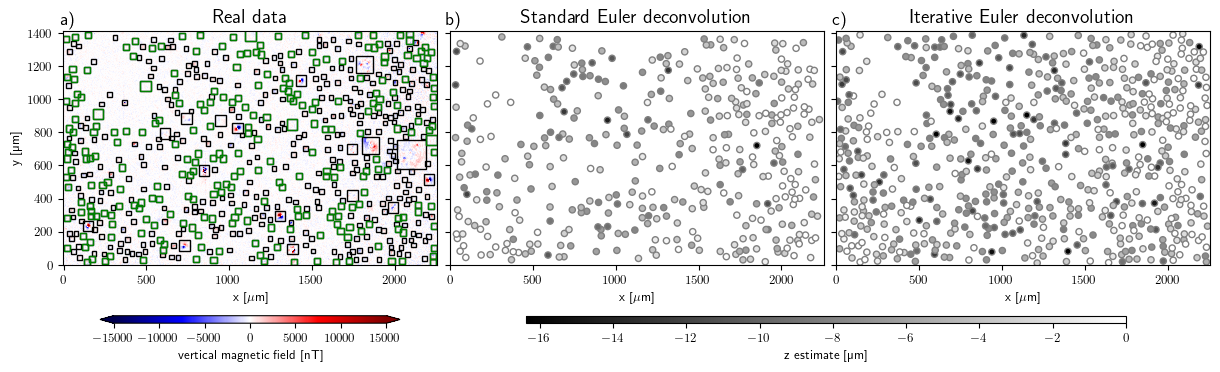

In [42]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

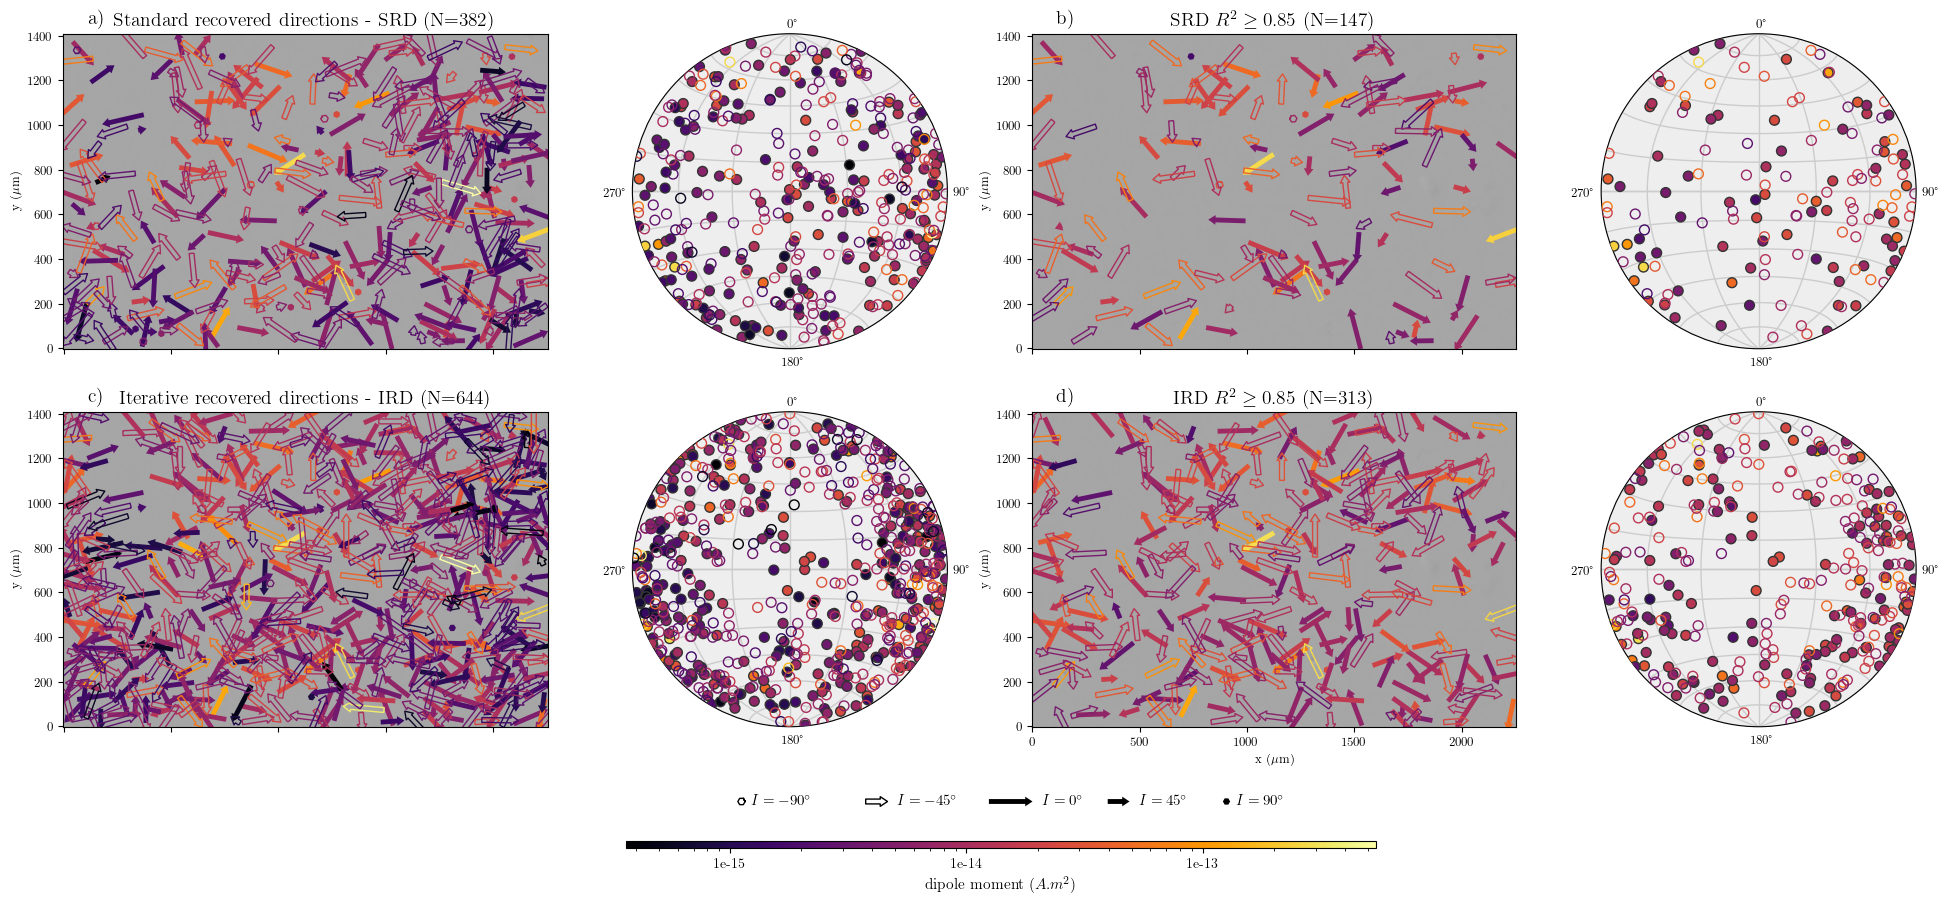

In [43]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

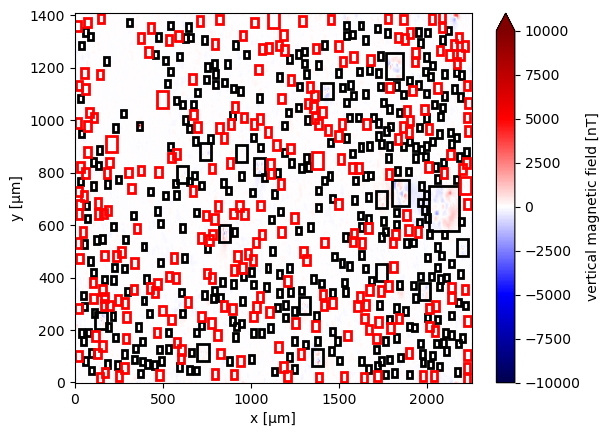

In [44]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [45]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.53920571,  0.99037217,  0.98195124,  0.93902916,  0.5861215 ,
        0.92525087,  0.97861229,  0.99406578,  0.96445528,  0.97323141,
        0.98254204,  0.9894043 ,  0.98171468,  0.91663882,  0.9845255 ,
        0.98931179,  0.98150176,  0.97858626,  0.94578546,  0.99311581,
        0.97031856,  0.93971098,  0.98720831,  0.99801837,  0.97511345,
        0.94769206,  0.99404876,  0.93947883,  0.9953741 ,  0.92843321,
        0.96850917,  0.98884607,  0.96841029,  0.94704777,  0.97202954,
        0.80075071,  0.1515006 ,  0.99097434,  0.63639787,  0.98687787,
        0.98191971,  0.97770083,  0.92509785,  0.85925602,  0.99261622,
        0.71954108,  0.94487891,  0.98220093,  0.92681748,  0.9826833 ,
        0.99748777,  0.91199918,  0.95342365,  0.98040101,  0.88736001,
        0.92167776,  0.859992  ,  0.75192814,  0.98195405,  0.35616253,
        0.84477305,  0.87991252,  0.96966719,  0.97671367,  0.95455845,
        0.85249888,  0.96291004,  0.96290116,  0.23397766,  0.86

# Show the observed and predicted data

In [46]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

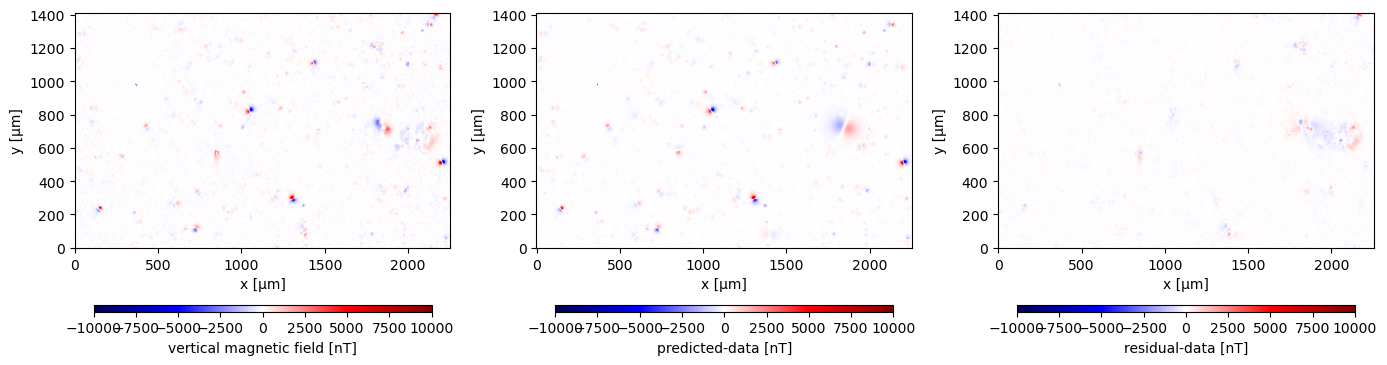

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.539205711730746


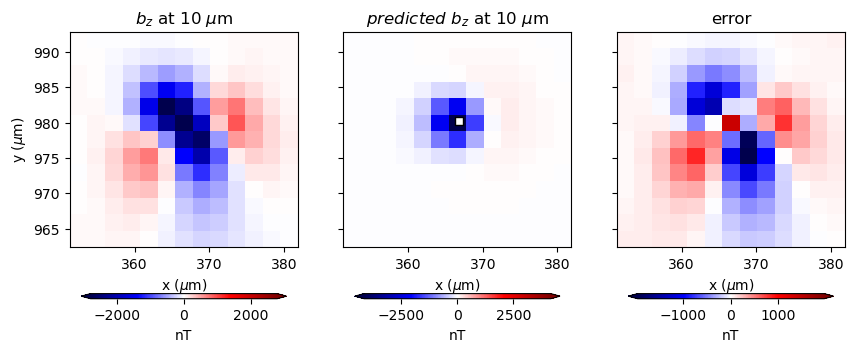

2
Individual source:   R2 = 0.9903721746279769


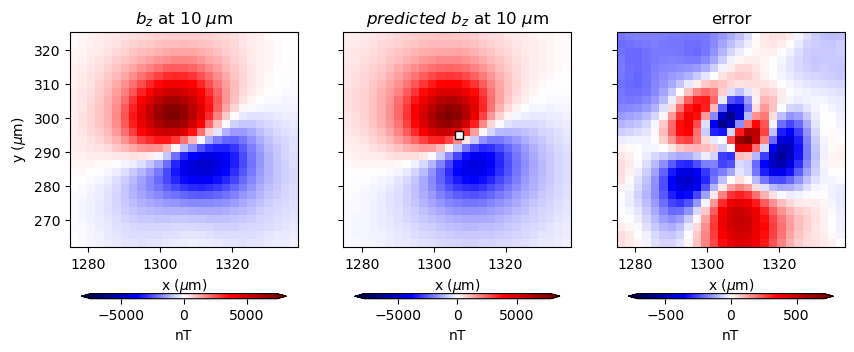

3
Individual source:   R2 = 0.9819512417950004


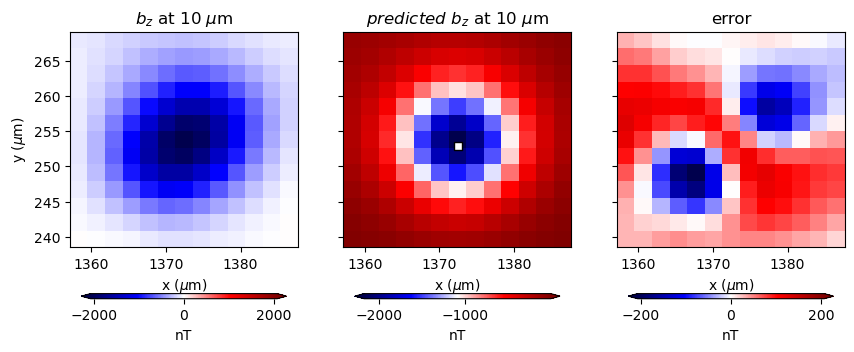

4
Individual source:   R2 = 0.9390291560535353


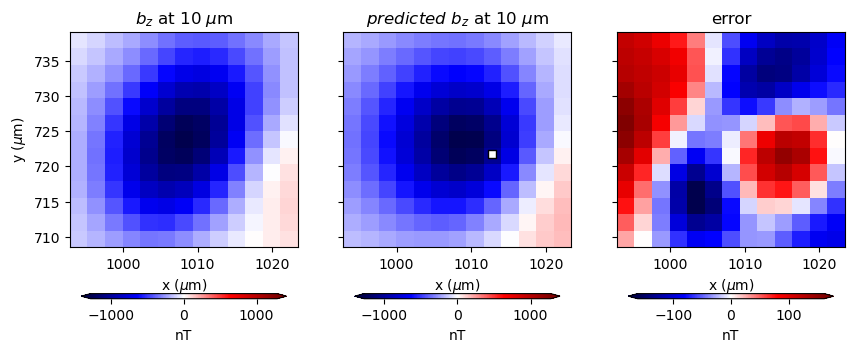

5
Individual source:   R2 = 0.5861215014247189


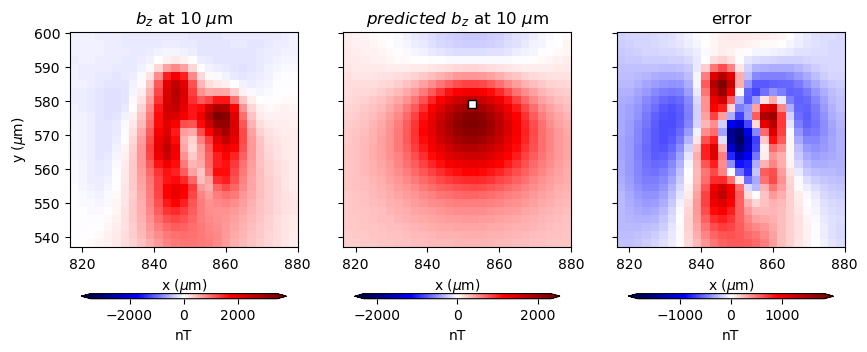

In [48]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [49]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [50]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)